Обучите классификатор, предсказывающий категорию объявления на Авито по его заголовку, описанию и цене. Метрика для оценки качества -- accuracy. Необходимо предоставить прокомментированный код (желательно на Python 2.x или 3.x, можно в Jupiter Notebook) для всех этапов решения задачи и результат скоринга файла test.csv с помощью предложенного классификатора (csv-файл с двумя столбцами: item_id, category_id).

Категории имеют иерархическую структуру, описанную в файле сategory.csv. Посчитайте также accuracy вашей модели на каждом уровне иерархии.

Для решения задачи можно использовать любые внешние модели, но не внешние данные. В случае сомнений по поводу возможности использования чего-либо напишите нам.

Cсылка на данные:
https://drive.google.com/drive/folders/1PzMQfrDTKmMbgHr0mJWMDfB3X9ZHsIxm?fbclid=IwAR1tGlzZVKwXIbNpt3tpjd4CuYPYN6Rk8bd2waYhmpc2WwYQZiZTVoNlPd0

In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from pymystem3 import Mystem
import re

import time

from wordcloud import WordCloud
import matplotlib.pyplot as plt


В качестве предикторов используются описания товаров, соединенные с их заголовками.

In [7]:
df_categ = pd.read_csv('./data/category.csv', index_col='category_id')
df_categ['cat_id'] = df_categ.index

df_train = pd.read_csv('./data/train.csv', index_col='item_id')
df_train = df_train.rename(columns={'description':'text', 'category_id':'cat_id'})

df_train['text'] = (df_train['title'] + ' ') * 2 + df_train['text']
df_train = df_train.drop(['title'], axis=1)

In [8]:
df = df_train.merge(df_categ, how='left', on='cat_id')

Использование облака слов позволяет визуально оценить входящий текст для лучшего понимания того, как необходимо проводить предобработку.

In [5]:
def word_cloud(text_array, text_title='Some title'):
    all_words = ' '.join(text_array)
    wordcloud = WordCloud(
        background_color = 'black',
        stopwords = stopwords.words('russian'),
        max_words = 200,
        max_font_size = 30,
        scale = 2,
        random_state = 1
    ).generate(all_words)

    fig = plt.figure(1, figsize=(30, 30))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

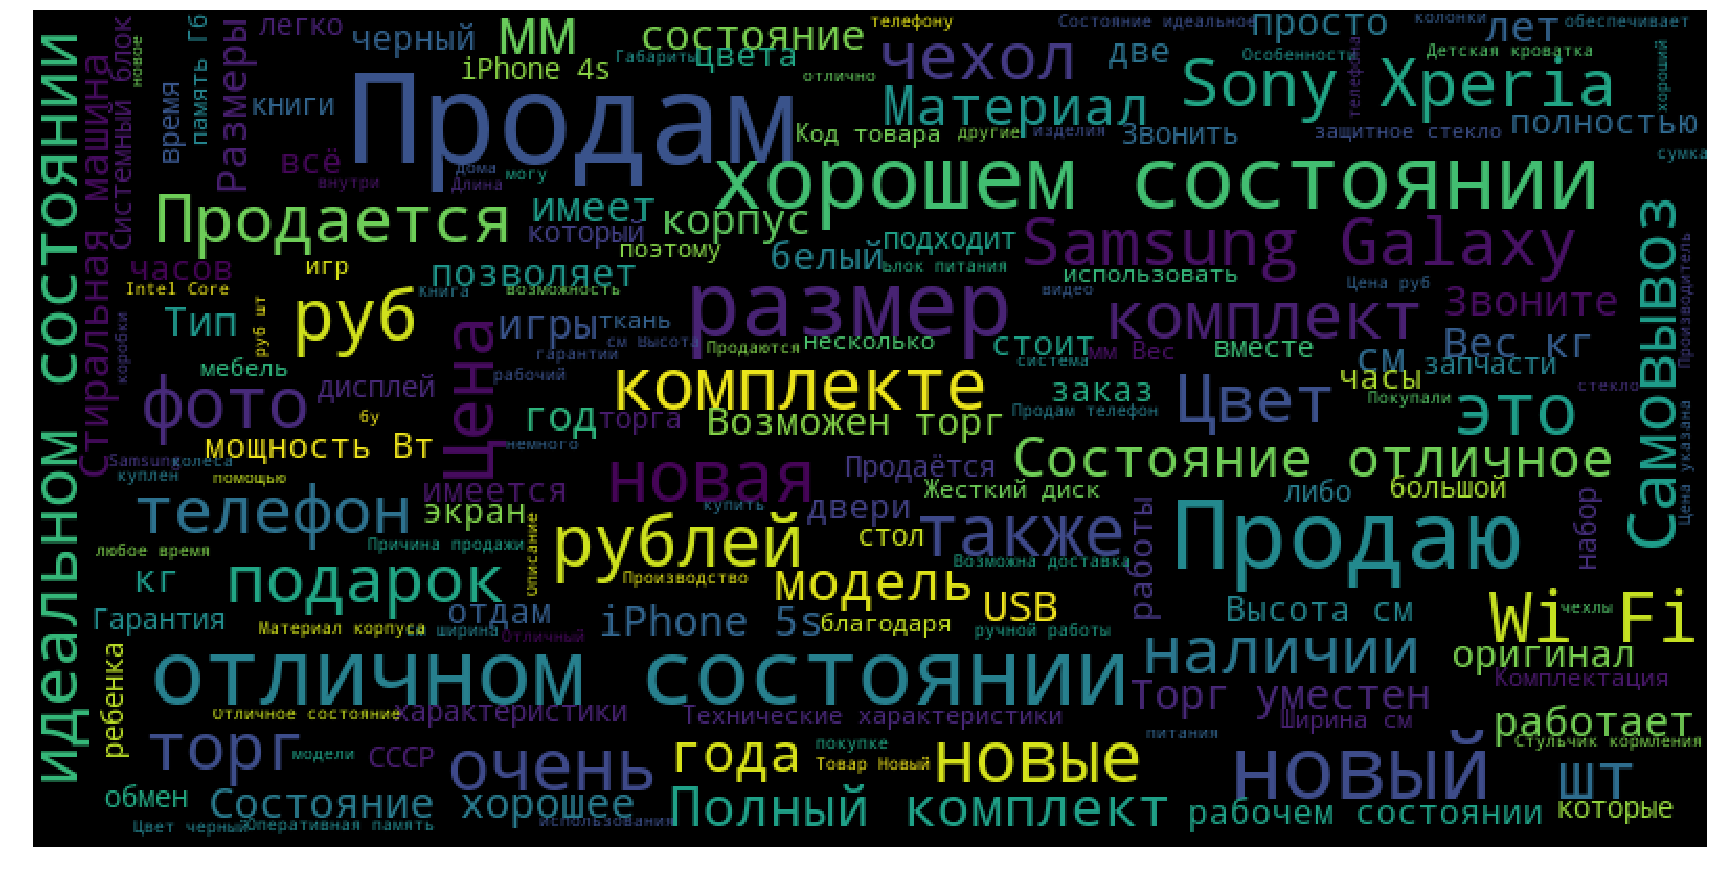

In [6]:
word_cloud(df['text'])

Для векторизации текста используется векторизация с tf-ifd.

In [9]:
tv = TfidfVectorizer(min_df=2, ngram_range=(1,3), sublinear_tf=True)

Очистка текста при помощи регулярного выражения. Это позволяет избавиться от знаков пунктуации, символов, отличающихся от английского и кириллицы, а так же смайлов эмодзи.

In [10]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Zа-яА-Я- ]', '', text)
    text = re.sub(r' +', ' ', text)
    return text

Перед векторизацией текст необходимо предобработать. В данном решении реализована следующая схема предобработки:   очистка регулярным выражением -> токенизация - > очистка от стоп-слов и не уникальных слов -> лемматизация.

In [11]:
def preproc(X):
        start_time = time.monotonic()
        lemma = Mystem()
        tokenizer = RegexpTokenizer(r'\w+')
        X = [clear_text(x) for x in X]
        dictinar = [tokenizer.tokenize(x) for x in X]
        stop = stopwords.words('russian') + ['продать', 'продаваться', 'продоваться', 'купить', 'продавать', 'продажа',
                  'новое', 'новый', 'хороший', 'отличный', 'состояние', 'идеальный',
                  'торг', 'цена', 'уместный','поэтому', 'также', 'обмен', 'срочно', 'который',
                  'сайт', 'это', 'вопрос', 'любой', 'причина', 'магазин', 'звонить', 'писать',
                  'очень', 'абсолютно', 'назад', 'использоваться', 'практически', 'возможный',
                 ]
        resX = []
        for otz in dictinar:
            otiv = [word for word in otz if word not in stop]
            otiv = [word for word in otiv if not word.isnumeric()]
            otiv = ' '.join(otiv)
            otiv = lemma.lemmatize(otiv)
            otiv = [word for word in otiv if word not in ['\n']]
            otiv = ''.join(otiv)
            resX.append(otiv)
        print('Completed ({:.2f} sec)'.format(time.monotonic() - start_time))
        return resX

In [12]:
def make_x_y(df, percentage=0.6):
        """
        Разбиение датасета на обучающую и тестовую выборки и векторизация текста
        """
        X,Y = (df['text'], df['cat_id'])
        
        p = int(len(X) * percentage)
        
        x_train = preproc(X[:p])
        x_test = preproc(X[p:])
        y_train = Y[:p]
        y_test = Y[p:]
        
        tv.fit(x_train)
        x_train = tv.transform(x_train)
        x_test = tv.transform(x_test)
        
        return x_train, y_train, x_test, y_test

В качестве алгоритма машинного обучения использован SGDClassifier, показавший наилучшую точность среди опробованных алгоритмов.

In [36]:
sgd = SGDClassifier(alpha=0.000001, random_state=1, class_weight='balanced', penalty='l2', loss='log', n_jobs=4)

In [15]:
x_train, y_train, x_test, y_test = make_x_y(df)

Completed (314.02 sec)
Completed (209.66 sec)


In [37]:
sgd.fit(x_train, y_train)
print('Train accuracy:', sgd.score(x_train, y_train),
      'Test accuracy:', sgd.score(x_test, y_test))

Train accuracy: 0.9597085560586973 Test accuracy: 0.8894574759840047


Загружаем тестовую выборку и делаем предсказания

In [38]:
df_test = pd.read_csv('./data/test.csv', index_col='item_id')
df_test = df_test.rename(columns={'description':'text'})

df_test['text'] = (df_test['title'] + ' ') * 2 + df_test['text']
df_test = df_test.drop(['title'], axis=1)

In [39]:
X = preproc(df_test['text'])
X = tv.transform(X)

Completed (276.65 sec)


In [40]:
predicts = sgd.predict(X)

In [41]:
predicts = pd.Series(predicts)

In [43]:
sub = pd.DataFrame({'item_id': df_test.index,
                    'category_id':predicts})
sub.to_csv('test.csv', index=False)